In [100]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np


In [76]:
df = pd.read_csv('diamond_full_data.csv')
df.head()

,carat,color,clarity,cut,table,depth,measurements,price
0,0.54,G,SI2,Excellent,58 %,62.2 %,5.2x5.22x3.24,$989
1,0.52,F,SI1,Excellent,57 %,62.1 %,5.13x5.15x3.19,"$1,111"
2,0.50,E,SI1,Excellent,60 %,60.8 %,5.09x5.13x3.11,"$1,197"
3,0.50,E,SI1,Excellent,61 %,60.7 %,5.13x5.15x3.12,"$1,225"
4,0.50,H,VS2,Excellent,57 %,63.3 %,5.03x5.06x3.19,"$1,155"


In [77]:
print(df.info())
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11385 entries, 0 to 11384
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   carat         11385 non-null  float64
 1   color         11385 non-null  object 
 2   clarity       11385 non-null  object 
 3   cut           11385 non-null  object 
 4   table         11385 non-null  object 
 5   depth         11385 non-null  object 
 6   measurements  11385 non-null  object 
 7   price         9107 non-null   object 
dtypes: float64(1), object(7)
memory usage: 711.7+ KB
None
carat              0
color              0
clarity            0
cut                0
table              0
depth              0
measurements       0
price           2278
dtype: int64


In [78]:
df.dropna(inplace=True)


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9107 entries, 0 to 11384
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   carat         9107 non-null   float64
 1   color         9107 non-null   object 
 2   clarity       9107 non-null   object 
 3   cut           9107 non-null   object 
 4   table         9107 non-null   object 
 5   depth         9107 non-null   object 
 6   measurements  9107 non-null   object 
 7   price         9107 non-null   object 
dtypes: float64(1), object(7)
memory usage: 640.3+ KB


In [80]:
df.head()

,carat,color,clarity,cut,table,depth,measurements,price
0,0.54,G,SI2,Excellent,58 %,62.2 %,5.2x5.22x3.24,$989
1,0.52,F,SI1,Excellent,57 %,62.1 %,5.13x5.15x3.19,"$1,111"
2,0.50,E,SI1,Excellent,60 %,60.8 %,5.09x5.13x3.11,"$1,197"
3,0.50,E,SI1,Excellent,61 %,60.7 %,5.13x5.15x3.12,"$1,225"
4,0.50,H,VS2,Excellent,57 %,63.3 %,5.03x5.06x3.19,"$1,155"


In [81]:
df["price"] = df["price"].replace('[\$,]', '', regex=True).astype(float)


df['table'] = df['table'].str.replace(' %', '').astype(float)
df['depth'] = df['depth'].str.replace(' %', '').astype(float)

df['measurements'] = df['measurements'].str.replace('X', 'x')
df[["x", "y", "z"]] = df["measurements"].str.split("x", expand=True)

# (Tuỳ chọn) Xoá cột measurements gốc
df.drop(columns=["measurements"], inplace=True)

# (Tuỳ chọn) Đổi kiểu x, y, z về float
df[["x", "y", "z","depth","table","carat"]] = df[["x", "y", "z","depth","table","carat"]].astype(float)


<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
C:\Users\quock\AppData\Local\Temp\ipykernel_37432\488478571.py:1: SyntaxWarning: invalid escape sequence '\$'
  df["price"] = df["price"].replace('[\$,]', '', regex=True).astype(float)


In [82]:
df.head()

,carat,color,clarity,cut,table,depth,price,x,y,z
0,0.54,G,SI2,Excellent,58.0,62.2,989.0,5.20,5.22,3.24
1,0.52,F,SI1,Excellent,57.0,62.1,1111.0,5.13,5.15,3.19
2,0.50,E,SI1,Excellent,60.0,60.8,1197.0,5.09,5.13,3.11
3,0.50,E,SI1,Excellent,61.0,60.7,1225.0,5.13,5.15,3.12
4,0.50,H,VS2,Excellent,57.0,63.3,1155.0,5.03,5.06,3.19


In [83]:
df.describe()

,carat,table,depth,price,x,y,z
count,9107.000000,9107.000000,9107.000000,9107.000000,9107.000000,9107.000000,9107.000000
mean,0.924654,57.624245,62.103635,6022.932799,6.044038,6.078621,3.766365
std,0.574320,1.504228,1.087881,18865.958721,0.937442,0.944968,0.599476
min,0.500000,53.000000,57.400000,461.000000,4.890000,4.950000,3.020000
25%,0.590000,57.000000,61.500000,1431.000000,5.370000,5.400000,3.310000
50%,0.800000,58.000000,62.400000,2663.000000,5.890000,5.930000,3.680000
75%,1.010000,59.000000,62.700000,4985.500000,6.380000,6.410000,4.000000
max,10.290000,64.000000,65.300000,981619.000000,13.850000,13.930000,8.680000


In [84]:
df[df["y"] == 0].index

Index([], dtype='int64')

### PRICE
#### ✅ Ưu điểm sau log-transform:

| **Yếu tố**              | **Trước log-transform (price)** | **Sau log-transform (log(price))**     |
|-------------------------|----------------------------------|----------------------------------------|
| **Skewness**            | Lệch phải mạnh                   | Gần chuẩn hơn                          |
| **Hiển thị chi tiết**   | Bị nén phần thấp                 | Trải đều, dễ nhìn hơn                  |
| **Quan sát phân cụm**   | Không rõ ràng                    | Có thể thấy được **2 cụm giá**         |

* Một mode chính nằm khoảng log(price) ≈ 7.5 (tương đương với khoảng 1,800 USD).

* Một mode phụ nhỏ hơn ở khoảng log(price) ≈ 8.5 (tương đương 5,000 USD).




In [85]:
df['log_price'] = np.log(df['price'])

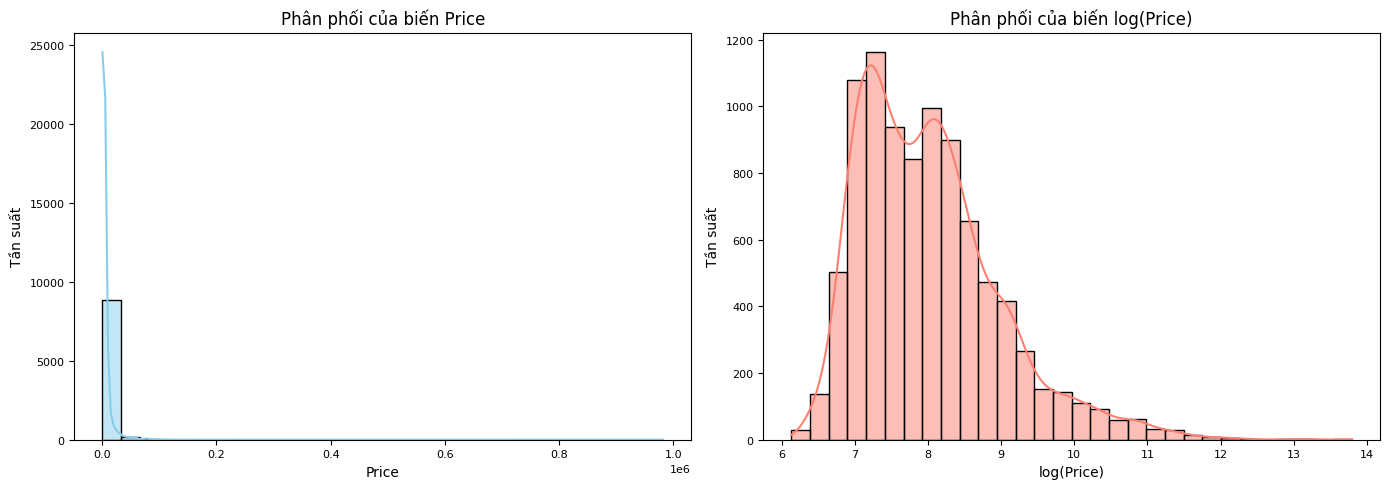

In [86]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Tạo thêm cột log_price
df['log_price'] = np.log(df['price'])

# Vẽ 2 biểu đồ cạnh nhau
plt.figure(figsize=(14, 5))

# Biểu đồ gốc - Price
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='price', kde=True, bins=30, color='skyblue')
plt.title('Phân phối của biến Price')
plt.xlabel('Price')
plt.ylabel('Tần suất')

# Biểu đồ log-transform
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='log_price', kde=True, bins=30, color='salmon')
plt.title('Phân phối của biến log(Price)')
plt.xlabel('log(Price)')
plt.ylabel('Tần suất')

plt.tight_layout()
plt.show()


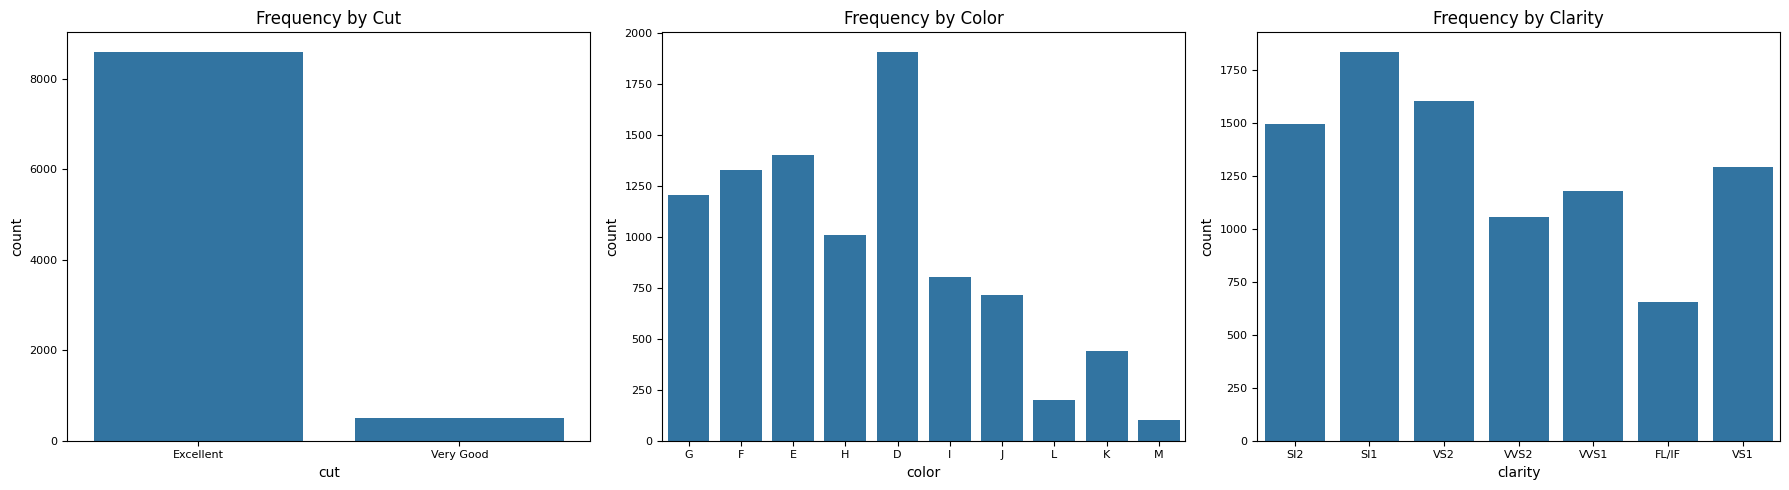

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Tải dữ liệu


plt.figure(figsize=(18, 5))

# Countplot theo 'cut'
plt.subplot(1, 3, 1)
sns.countplot(data=df, x='cut')
plt.title('Frequency by Cut')

# Countplot theo 'color'
plt.subplot(1, 3, 2)
sns.countplot(data=df, x='color')
plt.title('Frequency by Color')

# Countplot theo 'clarity'
plt.subplot(1, 3, 3)
sns.countplot(data=df, x='clarity')
plt.title('Frequency by Clarity')

plt.tight_layout()
plt.show()



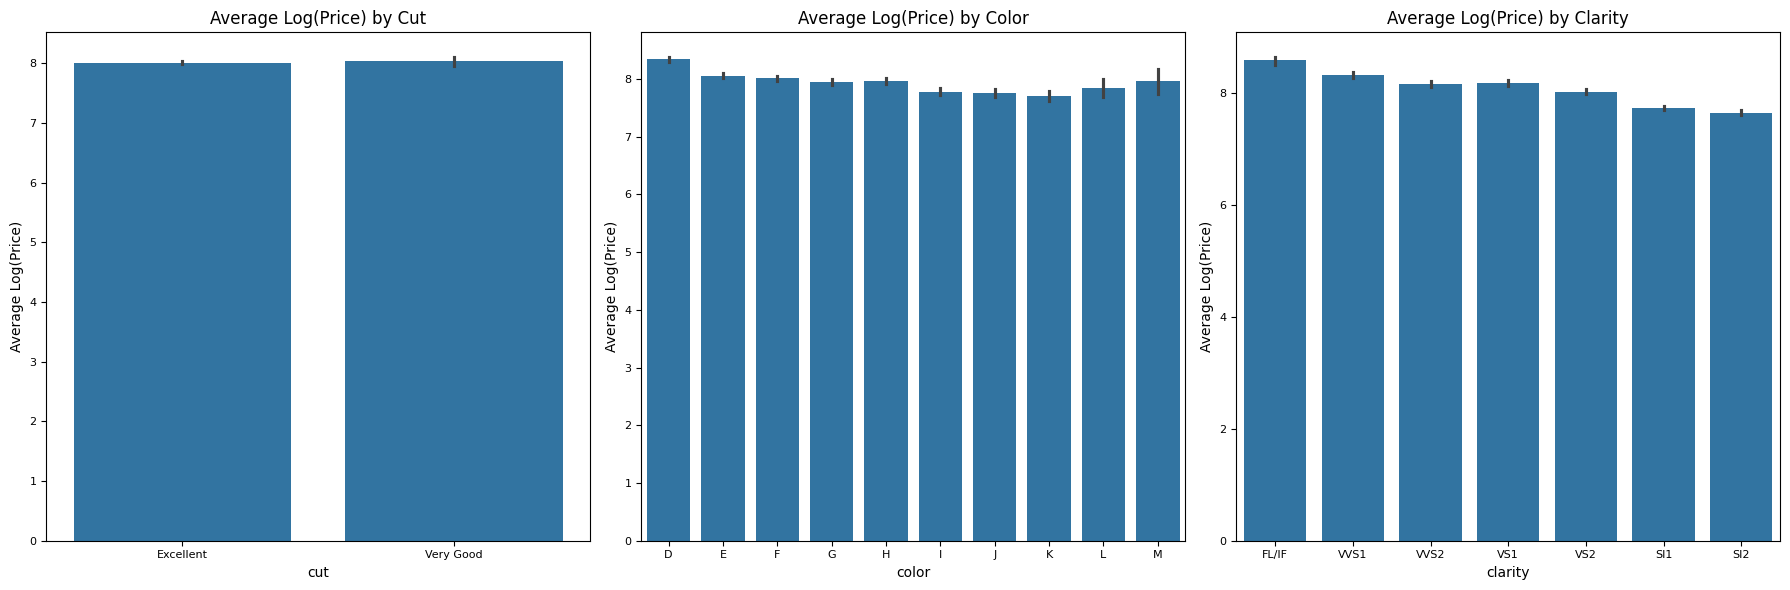

In [88]:
color_order = ['D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']
clarity_order = ['FL/IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2']
plt.figure(figsize=(18, 6))

# Barplot của trung bình log(price) theo 'cut'
plt.subplot(1, 3, 1)
sns.barplot(data=df, x='cut', y='log_price', estimator=np.mean)
plt.title('Average Log(Price) by Cut')
plt.ylabel('Average Log(Price)')

# Barplot của trung bình log(price) theo 'color'
plt.subplot(1, 3, 2)
sns.barplot(data=df, x='color', y='log_price', estimator=np.mean, order=color_order)
plt.title('Average Log(Price) by Color')
plt.ylabel('Average Log(Price)')

# Barplot của trung bình log(price) theo 'clarity'
plt.subplot(1, 3, 3)
sns.barplot(data=df, x='clarity', y='log_price', estimator=np.mean,  order=clarity_order)
plt.title('Average Log(Price) by Clarity')
plt.ylabel('Average Log(Price)')

plt.tight_layout()
plt.show()

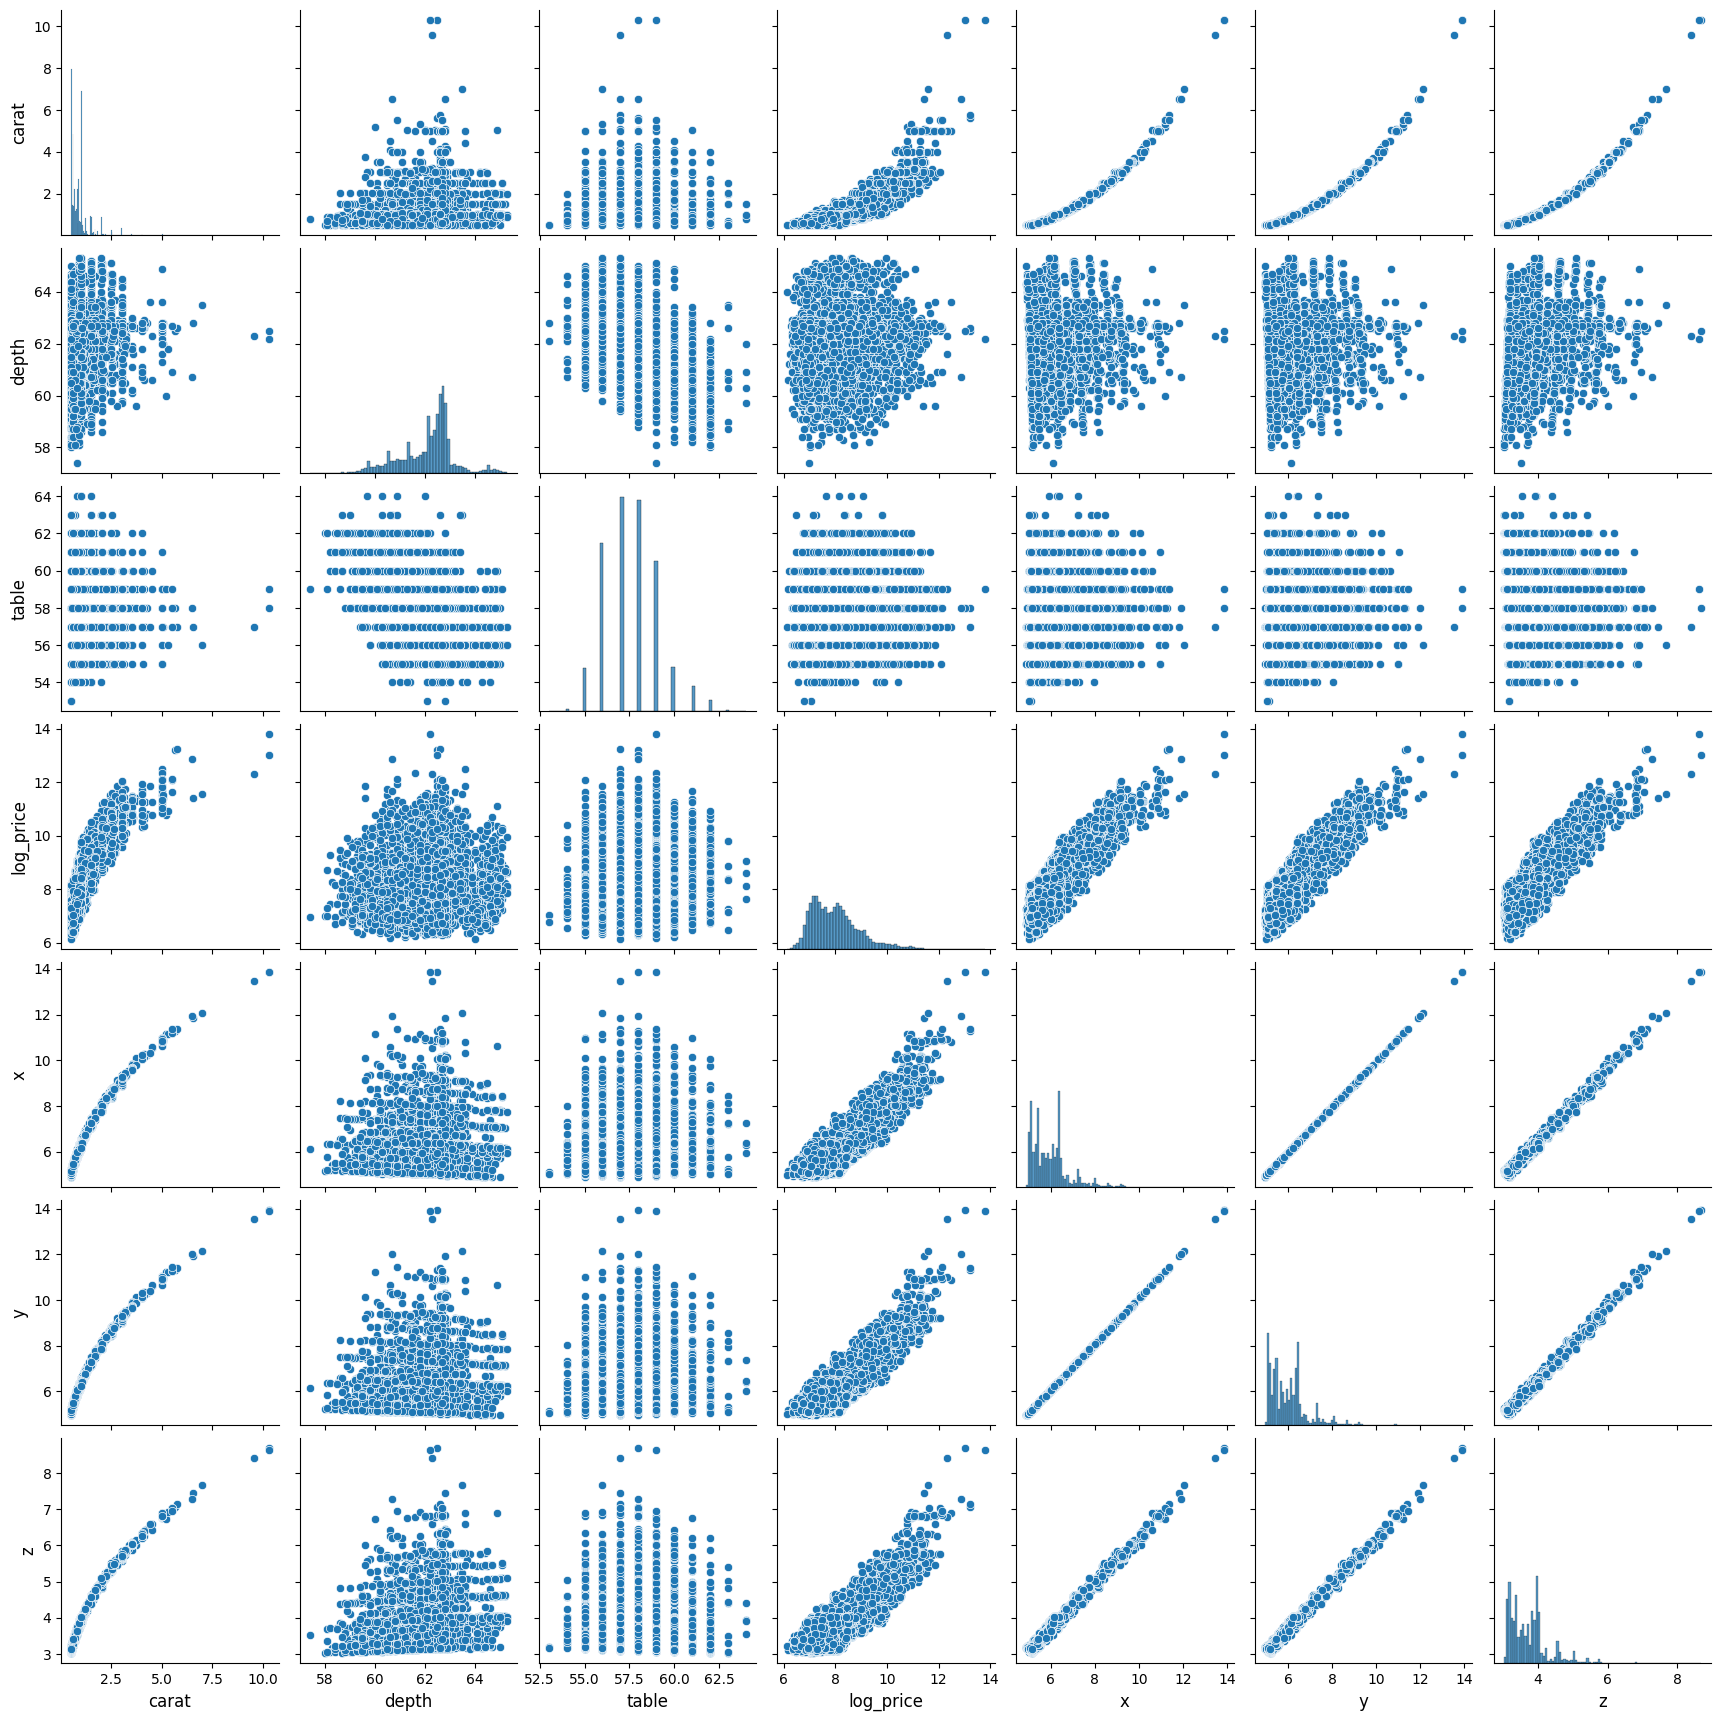

In [89]:
# Chọn các cột liên tục


plt.rcParams['axes.labelsize'] = 12 # Kích thước font cho nhãn trục x và y
plt.rcParams['xtick.labelsize'] = 10 # Kích thước font cho các số trên trục x
plt.rcParams['ytick.labelsize'] = 10 # Kích thước font cho các số trên trục y
continuous_vars = ['carat', 'depth', 'table', 'log_price', 'x', 'y', 'z']
sns.pairplot(df[continuous_vars])
plt.show()



In [90]:
df.head()

,carat,color,clarity,cut,table,depth,price,x,y,z,log_price
0,0.54,G,SI2,Excellent,58.0,62.2,989.0,5.20,5.22,3.24,6.896694
1,0.52,F,SI1,Excellent,57.0,62.1,1111.0,5.13,5.15,3.19,7.013016
2,0.50,E,SI1,Excellent,60.0,60.8,1197.0,5.09,5.13,3.11,7.087574
3,0.50,E,SI1,Excellent,61.0,60.7,1225.0,5.13,5.15,3.12,7.110696
4,0.50,H,VS2,Excellent,57.0,63.3,1155.0,5.03,5.06,3.19,7.051856


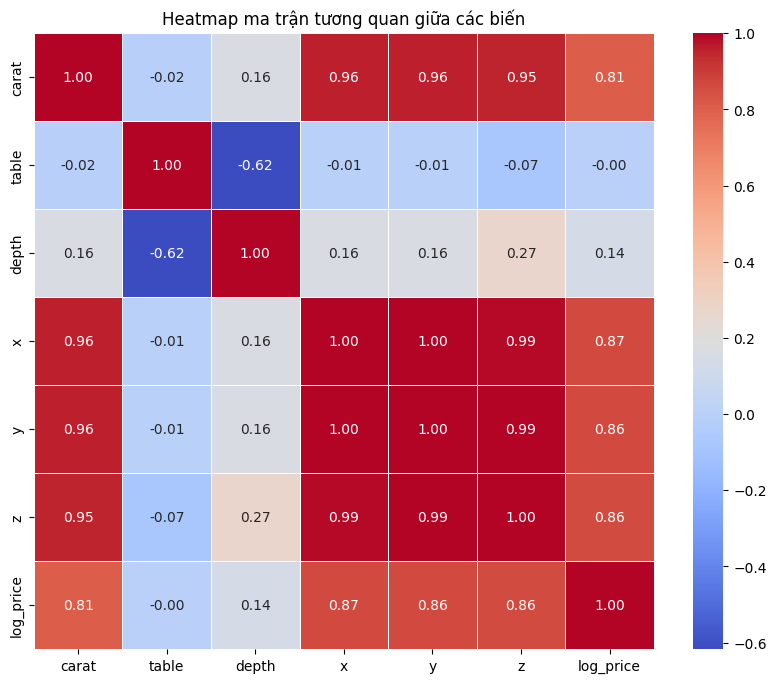

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tính ma trận tương quan
corr = df.drop(['price'],axis =1).corr(numeric_only=True)

# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap ma trận tương quan giữa các biến')
plt.show()


In [92]:
X = df.drop(['price', 'log_price'], axis=1) # Các biến độc lập
y = df['log_price'] # Biến mục tiêu

# Phân tầng theo 'color'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['color'])

So sánh phân bố của biến liên tục giữa Train và Test set:


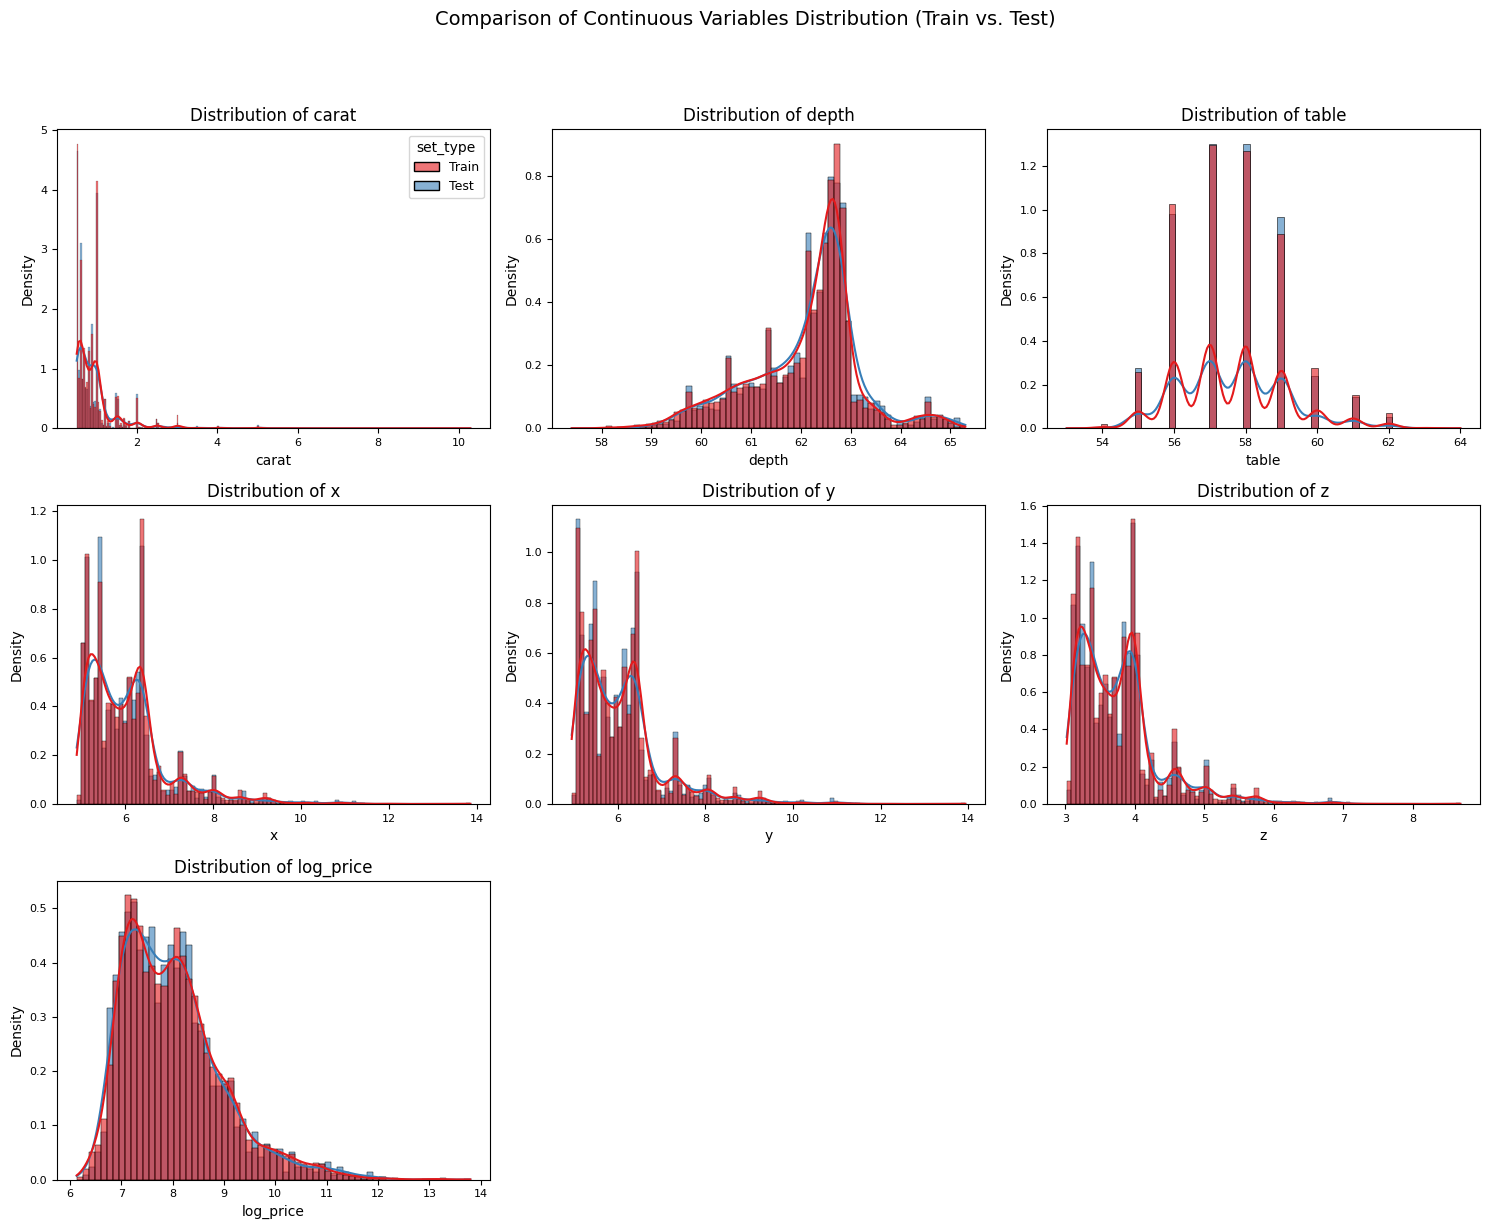


So sánh phân bố của biến danh mục giữa Train và Test set:


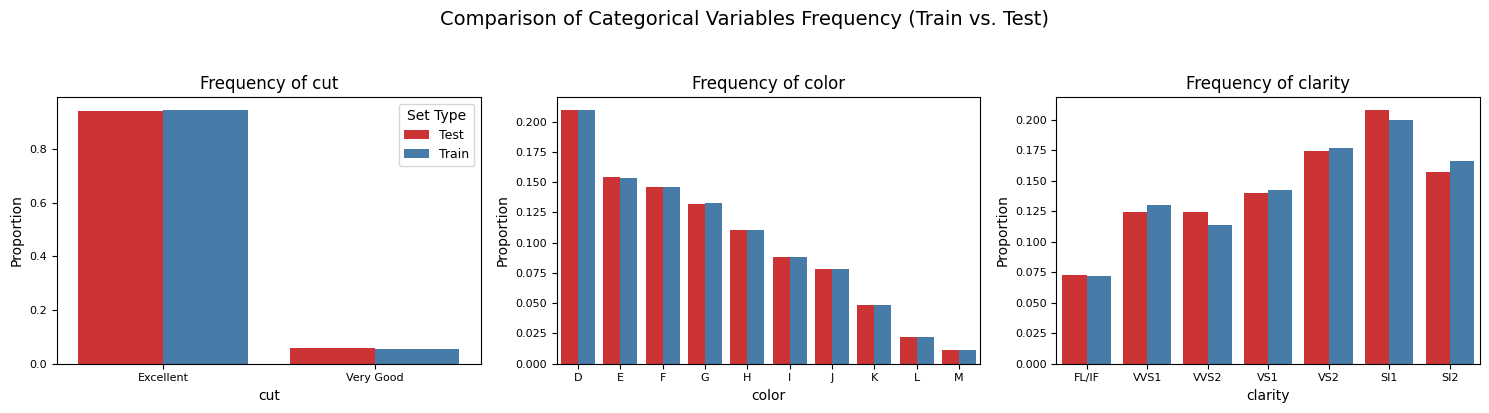

In [93]:
df_viz = df.copy() # Tạo một bản sao để thêm cột '_set_type' mà không ảnh hưởng đến df gốc

X = df_viz.drop(['price', 'log_price'], axis=1) # Các biến độc lập
y = df_viz['log_price'] # Biến mục tiêu

# Phân tầng theo 'color'
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X['color']
)

# Gắn lại biến mục tiêu vào X_train và X_test để dễ dàng visualize
X_train['log_price'] = y_train
X_test['log_price'] = y_test

# Thêm cột nhận dạng 'set_type' vào mỗi tập để phân biệt khi vẽ
X_train['set_type'] = 'Train'
X_test['set_type'] = 'Test'

# Nối lại X_train và X_test để vẽ biểu đồ so sánh dễ dàng hơn
combined_df = pd.concat([X_train, X_test])

# --- Danh sách các biến để vẽ biểu đồ ---
categorical_vars = ['cut', 'color', 'clarity']
continuous_vars = ['carat', 'depth', 'table', 'x', 'y', 'z', 'log_price']

# --- Đặt lại kích thước font cho các nhãn biểu đồ ---
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9 # Kích thước font cho legend

# --- Cài đặt palette màu sắc tương phản rõ ràng ---
custom_palette = sns.color_palette("Set1", n_colors=2) # Ví dụ: màu đỏ và xanh

# --- Vẽ biểu đồ cho biến liên tục (Histogram) trên cùng một Figure ---
print("So sánh phân bố của biến liên tục giữa Train và Test set:")
# Xác định số lượng hàng và cột cho subplot
num_cont_vars = len(continuous_vars)
n_cols_cont = 3 # Số cột bạn muốn hiển thị
n_rows_cont = (num_cont_vars + n_cols_cont - 1) // n_cols_cont # Tính số hàng cần thiết

fig_cont, axes_cont = plt.subplots(n_rows_cont, n_cols_cont, figsize=(5 * n_cols_cont, 4 * n_rows_cont))
axes_cont = axes_cont.flatten() # Biến đổi mảng axes 2D thành 1D để dễ lặp

for i, var in enumerate(continuous_vars):
    ax = axes_cont[i]
    sns.histplot(data=combined_df, x=var, hue='set_type', kde=True, palette=custom_palette,
                 stat='density', common_norm=False, ax=ax, alpha=0.6) # Thêm alpha để dễ nhìn khi chồng lên
    ax.set_title(f'Distribution of {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Density')
    
    if i != 0: # Xóa legend ở các subplot còn lại sau khi đã đặt tiêu đề cho cái đầu tiên
            ax.get_legend().remove()

# Xóa các subplot trống nếu có
for j in range(i + 1, len(axes_cont)):
    fig_cont.delaxes(axes_cont[j])

plt.suptitle('Comparison of Continuous Variables Distribution (Train vs. Test)', y=1.02, fontsize=14) # Tiêu đề chung cho figure
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Điều chỉnh layout để không bị cắt tiêu đề
plt.show()

# --- Vẽ biểu đồ cho biến danh mục (Barplot với tần số) trên cùng một Figure ---
print("\nSo sánh phân bố của biến danh mục giữa Train và Test set:")
num_cat_vars = len(categorical_vars)
n_cols_cat = 3
n_rows_cat = (num_cat_vars + n_cols_cat - 1) // n_cols_cat

fig_cat, axes_cat = plt.subplots(n_rows_cat, n_cols_cat, figsize=(5 * n_cols_cat, 4 * n_rows_cat))
axes_cat = axes_cat.flatten()

for i, var in enumerate(categorical_vars):
    ax = axes_cat[i]

    # Tính toán tần số (tỷ lệ phần trăm)
    # Group by var và set_type, sau đó tính số lượng và chuyển thành tỷ lệ
    df_freq = combined_df.groupby('set_type')[var].value_counts(normalize=True).rename('proportion').reset_index()

    # Sắp xếp các cấp độ cho dễ nhìn nếu là biến ordinal
    order = None
    if var == 'color':
        order = ['D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']
    elif var == 'clarity':
        order = ['FL/IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2'] # Đảm bảo thêm I1, I2, I3 nếu có
    elif var == 'cut':
        order = ['Excellent', 'Very Good'] # Đảm bảo thêm các loại khác nếu có

    sns.barplot(data=df_freq, x=var, y='proportion', hue='set_type', palette=custom_palette, order=order, ax=ax)
    ax.set_title(f'Frequency of {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Proportion')
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right') # Xoay nhãn nếu cần
    if i == 0: # Chỉ hiển thị legend cho subplot đầu tiên
        ax.legend(title='Set Type')
    else:
        ax.get_legend().remove() # Xóa legend ở các subplot còn lại

# Xóa các subplot trống nếu có
for j in range(i + 1, len(axes_cat)):
    fig_cat.delaxes(axes_cat[j])

plt.suptitle('Comparison of Categorical Variables Frequency (Train vs. Test)', y=1.02, fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [94]:
X = df.drop(['price', 'log_price'], axis=1)
y = df['log_price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X['color']
)
numerical_cols = ['carat', 'depth', 'table', 'x', 'y', 'z']
categorical_cols = ['cut', 'color', 'clarity'] 

In [95]:
cut_categories = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
color_categories = ['M', 'L', 'K', 'J', 'I', 'H', 'G', 'F', 'E', 'D'] # Từ kém nhất (0) đến tốt nhất (9)
clarity_categories = ['SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'FL/IF'] # Từ kém nhất (0) đến tốt nhất (6)

scaler = StandardScaler()

# Khởi tạo OrdinalEncoder cho từng cột danh mục
# Chúng ta sẽ xử lý từng cột riêng biệt
encoder_cut = OrdinalEncoder(categories=[cut_categories], handle_unknown='use_encoded_value', unknown_value=-1)
encoder_color = OrdinalEncoder(categories=[color_categories], handle_unknown='use_encoded_value', unknown_value=-1)
encoder_clarity = OrdinalEncoder(categories=[clarity_categories], handle_unknown='use_encoded_value', unknown_value=-1)


# 2. FIT (Học tham số) trên X_train và TRANSFORM cho cả X_train và X_test

# --- Xử lý biến liên tục ---
print("Processing numerical columns...")
# Fit scaler trên X_train của các cột số
scaler.fit(X_train[numerical_cols])

# Transform X_train và X_test sử dụng scaler đã fit
X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
print("Numerical columns processed.\n")

# --- Xử lý biến danh mục ---
print("Processing categorical columns...")

# Fit và Transform cho 'cut'
encoder_cut.fit(X_train[['cut']])
X_train['cut'] = encoder_cut.transform(X_train[['cut']])
X_test['cut'] = encoder_cut.transform(X_test[['cut']])

# Fit và Transform cho 'color'
encoder_color.fit(X_train[['color']])
X_train['color'] = encoder_color.transform(X_train[['color']])
X_test['color'] = encoder_color.transform(X_test[['color']])

# Fit và Transform cho 'clarity'
encoder_clarity.fit(X_train[['clarity']])
X_train['clarity'] = encoder_clarity.transform(X_train[['clarity']])
X_test['clarity'] = encoder_clarity.transform(X_test[['clarity']])

print("Categorical columns processed.\n")


# --- Kiểm tra kết quả ---
print("--- X_train sau tiền xử lý ---")
print(X_train.head())
print(f"Shape: {X_train.shape}\n")

print("--- X_test sau tiền xử lý ---")
print(X_test.head())
print(f"Shape: {X_test.shape}\n")

# Kiểm tra mean và std của các cột số trong X_train (nên gần 0 và 1)
print("Kiểm tra trung bình và độ lệch chuẩn của các cột số trong X_train:")
print(X_train[numerical_cols].mean())
print(X_train[numerical_cols].std())

print("\nKiểm tra trung bình và độ lệch chuẩn của các cột số trong X_test (có thể không chính xác 0 và 1 nhưng gần):")
print(X_test[numerical_cols].mean())
print(X_test[numerical_cols].std())

print("\nKiểm tra giá trị mã hóa của biến danh mục trong X_train (xem các số nguyên đã gán):")
print(X_train[categorical_cols].head())

Processing numerical columns...
Numerical columns processed.

Processing categorical columns...
Categorical columns processed.

--- X_train sau tiền xử lý ---
         carat  color  clarity  cut     table     depth         x         y  \
4101 -0.736199    7.0      2.0  4.0  2.885633 -0.087444 -1.071687 -1.068010   
3146 -0.580723    7.0      3.0  4.0 -1.073406  0.187454 -0.763070 -0.761821   
7106 -0.701649    8.0      5.0  4.0  0.246274  0.553986 -1.007835 -1.004660   
1892  0.162109    7.0      4.0  4.0  1.565953 -1.736837  0.492683  0.484049   
721  -0.580723    3.0      5.0  4.0  0.906114 -1.920103 -0.646008 -0.656239   

             z  
4101 -1.061509  
3146 -0.728584  
7106 -0.928339  
1892  0.270193  
721  -0.828461  
Shape: (7285, 9)

--- X_test sau tiền xử lý ---
          carat  color  clarity  cut     table     depth         x         y  \
10048  0.127559    3.0      0.0  4.0  0.906114 -0.179077  0.375621  0.367909   
9120   7.573154    1.0      1.0  4.0 -1.073406 -0.270710

In [99]:

# df_encoded = pd.get_dummies(df, columns=["cut", "color", "clarity"], drop_first=True)

# # Bước 3: Tách X và y
# X = df_encoded.drop(columns="price")
# y = df_encoded["price"]

# # Bước 4: Lấy mẫu phân tầng (stratified sampling) theo 'cut'
# # Vì cut đã bị encode nên ta cần tách ra label trước khi encode để dùng cho phân tầng
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42, 
#     # stratify=df["cut"],  # Phân tầng theo 'cut'
    
# )

# (Tùy chọn) Bước 5: Chuẩn hóa dữ liệu nếu muốn
# Không cần thiết cho Random Forest, nhưng có thể bật nếu dùng Linear Regression
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Bước 6: Huấn luyện mô hình Random Forest
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)
feature_importances = model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("--- Tầm quan trọng của các đặc trưng (Feature Importances) ---")
print(importance_df)

# Bước 7: Dự đoán và đánh giá
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📉 RMSE: {rmse:.2f}")
print(f"📈 R² score: {r2:.4f}")

--- Tầm quan trọng của các đặc trưng (Feature Importances) ---
   Feature  Importance
6        x    0.663426
1    color    0.104988
2  clarity    0.092180
7        y    0.073059
0    carat    0.039706
8        z    0.020841
5    depth    0.003376
4    table    0.002216
3      cut    0.000209
📉 RMSE: 0.14
📈 R² score: 0.9790


In [98]:
model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# 6. Dự đoán và đánh giá
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📉 RMSE: {rmse:.2f}")
print(f"📈 R² score: {r2:.4f}")

📉 RMSE: 0.13
📈 R² score: 0.9816


In [103]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📉 RMSE: {rmse:.2f}")
print(f"📈 R² score: {r2:.4f}")

📉 RMSE: 0.19
📈 R² score: 0.9617
